# Project milestone 4
Tadaa - Jonathan Haenni, Lea Schmidt, Danny Kohler
> This work presents the creative extension of the publication from J. Penney : "Chilling effects : Online surveillance and Wikipedia use".

---

## Abstract
The goal of this work is to observe if the public action of Greta Thunberg and her continual incitation for people to educate themselves on the subject of climate change has actually made a difference. This effect would be diametrically different from a chilling effect in that it pushes people to get educated on a subject, effectively arguably increasing their levels of freedom. This effect shall henceforth be called an "Empowering effect".

First and foremost, the selected interest period depends on the choice of events that will be the pivots of the interrupted time series analysis. (ITS) These events are as follows: the school strike of August 20, 2018 led by Greta Thunberg, the 2018 United Nations Climate Change Conference (COP24) on December 14, 2018 and the summit of the United Nations on September 23, 2019. The period of analysis is between January 2018 and February 2020. As seen in HW1, the Covid-19 pandemic influences the pageviews a lots and we will therefore not elongate this analysis onto 2020.

The data considered here comes from Wikipedia. We will consider 150 [ADAPT VALUE] Wikipedia articles divided into 3 groups. The first group is the treatment dataset, containing the Wikipedia articles related to climate change issues. The second group is a quasi-control group, where the topics considered are related to nature, without being related to climate change directly. The third group is another control group composed of popular articles simply reflecting the trends on Wikipedia. It is the same as the one used in the publication. The data sets considered give the number of pageviews per day for each article, within the time period considered.

As already hinted at, the analysis will be very similar to the one used in the publication - an ITS analysis with segmented linear regressions.

If the first group features significant changes in pageviews and the control groups don't across the selected period, we will be able to conclude that the "Empowering Effect" exists and we will be able to compare it to the chilling effect considered in the publication.

---

## Analytical Methods


To perform the comparison between the periods, we will use a trivial mean comparison as a non-model empirical findings in a first time.

Then we will use a customized interrupted time serie analysis as depicted by Lagarde explained further. The purpose is to use a unique linear regression through all the periods with a dataset taking into account the influence of the data only on its corresponding period. 

>> Lagarde ITS : $$y_t = \gamma_0 + \gamma_1  \times preslope + \gamma_2  \times intervention + \gamma_3  \times postslope + \varepsilon_t$$
>
>This is the equation used by Lagarde (2012) mentioned in the paper where $y_t$ is the outcome at time $t$, $\gamma_0$ is the baseline level at time 0, $\gamma_1$ is the estimation of the trend in the outcome before the intervention, $\gamma_2$ is the estimation of the structural structural trend without intervention and $\gamma_3$ is the estimation of the trend in the outcome after the intervention. We can see how the data has to be structured to be used like this in the Table 2 from the said paper just below. The analyzed event from Table 2 happened in April 2006, hence we can see this month has the value 1 for "intervention" in the Table. It means **the month of the event has to be included in the second period for the regression computation**.

>REFERENCES : Lagarde, Mylene. “How to Do (or Not to Do) … Assessing the Impact of a Policy Change with Routine Longitudinal Data.” Health Policy and Planning 27, no. 1 (January 1, 2012): 76–83. >https://doi.org/10.1093/heapol/czr004.
> Table 2, page 80.

><img src="./Lagarde.png">

We have modified the technique in order to be compliant with our data since we have multiple events contrary to Lagarde who computes the regression around one unique event. The modifications are as follow :

>Each event $n$ has its proper column $intervention_n$ that is filled of 1 during the months correspond to the period after the event, where it has influence on. There are then $n+1$ columns correspond to each slope between the events, before the first event and after the last event. The equation for the linear regression is : $$y_t = \gamma_0 + \gamma_1  \times intervention_1 + \dotsm + \gamma_n  \times intervention_n + \gamma_{n+1}  \times slope_1 + \dotsm + \gamma_{2n+1}  \times slope_{n+1} + \varepsilon_t$$

After having plotted the dataset, we will check outliers with the Cook's D distances on the linear regression and then we will detect the accountable articles with Z-score and its rule of Thumb ([-3:3]). 

We will check for auto-correlation/seasonality after this and correct it if necessary.

Finally we will replot all the corrected dataset.

## 1. Data loading and data wrangling

### 1.1 Loading

> We simply load the csv's that have been extracted from 

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# # Load the climate change articles data
# art_cc1 = pd.read_csv('data/pageviews-10-pro.csv').copy()
# art_cc2 = pd.read_csv('data/pageviews-20-pro.csv').copy()
# art_cc3 = pd.read_csv('data/pageviews-30-pro.csv').copy()
# art_cc4 = pd.read_csv('data/pageviews-40-pro.csv').copy()
# art_cc5 = pd.read_csv('data/pageviews-50-pro.csv').copy()

# # Load the control (popular) articles data
# art_control1 = pd.read_csv('data/pageviews-10-control.csv').copy()
# art_control2 = pd.read_csv('data/pageviews-20-control.csv').copy()
# art_control3 = pd.read_csv('data/pageviews-30-control.csv').copy()
# art_control4 = pd.read_csv('data/pageviews-40-control.csv').copy()
# #art_control5 = pd.read_csv('data/pageviews-50-control.csv').copy()

# Load the climate change articles science data
sci_art_cc1 = pd.read_csv('data/Pro_climate/pageviews-group1-biodiv.csv').copy()
sci_art_cc2 = pd.read_csv('data/Pro_climate/pageviews-group1-energy.csv').copy()
sci_art_cc3 = pd.read_csv('data/Pro_climate/pageviews-group1-meteo.csv').copy()
sci_art_cc4 = pd.read_csv('data/Pro_climate/pageviews-group1-pesticides.csv').copy()
sci_art_cc5 = pd.read_csv('data/Pro_climate/pageviews-groupe1-earth.csv').copy()

# Load the control articles science data
sci_art_control1 = pd.read_csv('data/Group_control/pageviews-group2-anatomy.csv').copy()
sci_art_control2 = pd.read_csv('data/Group_control/pageviews-group2-genetics.csv').copy()
sci_art_control3 = pd.read_csv('data/Group_control/pageviews-group2-optic.csv').copy()
sci_art_control4 = pd.read_csv('data/Group_control/pageviews-group2-philo.csv').copy()
sci_art_control5 = pd.read_csv('data/Group_control/pageviews-group2-social.csv').copy()

# Load the control articles science data
sci_art_pop1 = pd.read_csv('data/Group_popular_2017/pageviews-control-2017.csv').copy()
sci_art_pop2 = pd.read_csv('data/Group_popular_2017/pageviews-control-2017-1.csv').copy()
sci_art_pop3 = pd.read_csv('data/Group_popular_2017/pageviews-control-2017-2.csv').copy()
sci_art_pop4 = pd.read_csv('data/Group_popular_2017/pageviews-control-2017-3.csv').copy()
sci_art_pop5 = pd.read_csv('data/Group_popular_2017/pageviews-control-2017-4.csv').copy()

# Merge all datasets together for each corpus
# art_cc=art_cc1.merge(art_cc2).merge(art_cc3).merge(art_cc4).merge(art_cc5)
# art_control_popular=art_control1.merge(art_control2).merge(art_control3).merge(art_control4)#.merge(art_control5)
sci_art_cc=sci_art_cc1.merge(sci_art_cc2).merge(sci_art_cc3).merge(sci_art_cc4).merge(sci_art_cc5)
sci_art_control=sci_art_control1.merge(sci_art_control2).merge(sci_art_control3).merge(sci_art_control4).merge(sci_art_control5)
sci_art_pop=sci_art_pop1.merge(sci_art_pop2).merge(sci_art_pop3).merge(sci_art_pop4).merge(sci_art_pop5)
# Display to illustrate the structure
sci_art_control.head()

C:\Users\Dan\AppData\Roaming\Python\Python38\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


,Date,Bone,Kidney,Neurology,Quadriceps femoris muscle,Cranial nerve nucleus,Fetus,Efferent limb,Mononeuropathy multiplex,Kneecap,...,Dendrite,Hydrolysis,Murder,Autocracy,Cognition,ATP synthase,Kindness,Quantitative research,Stigmatize,House Work
0,2017-01-01,1533,2582,1128,793,96,694,1,0,10,...,232,705,1804,756,1160,211,265,436,4,17
1,2017-01-02,2058,3015,1599,1156,138,853,2,1,19,...,336,1071,2070,1018,1700,338,318,824,1,37
2,2017-01-03,2394,3298,2000,1414,145,912,0,1,13,...,395,1295,2283,1090,1772,423,492,989,0,25
3,2017-01-04,2828,3685,2035,1624,222,941,3,1,12,...,453,1420,2767,1005,1850,502,420,1160,6,27
4,2017-01-05,2845,3595,2021,1579,175,952,1,0,15,...,482,1442,2662,1059,2003,481,426,1156,2,24


>Here we define all the intervals between the mentioned event about the climate : the school strike of August 20, 2018 led by Greta Thunberg, the 2018 United Nations Climate Change Conference (COP24) on December 14, 2018 and the summit of the United Nations on September 23, 2019. The modularity of the code allows to simply add or put out an event without changing the code.

In [2]:
INTERVALS_2 =[["2018-01","2018-07"],["2018-08","2018-11"],["2018-12","2019-08"],["2019-09","2020-02"]]
#1er janvier 2017 jusquau 31 aout 2020
INTERVALS =[("2017-01","2018-07"),("2018-08","2018-11"),("2018-12","2019-08"),("2019-09","2020-08")]

>Here we have a function to aggregate the dataframe. It creates a dataframe with the index as the datetimes by month and with two columns as the number of the month and the pageviews count over all the article during the said month. 

In [3]:
def aggregate(df, freq="MS", drop = None, events=INTERVALS, normalization=False) :
    """A function to aggregate the dataframe as a Serie sorted by month
    with the total number of pageviews per month. With the numbering of each
    month of the timeserie. drop is used to drop a list of articles in the 
    dataframe. freq is used to choice the frequency of the aggregation. 
    Add the columns intervention, preslope and postslope in the Lagarde fashion.
    To perform the aggregation, it is necessary to give the date of the analyzed 
    event according to the chosen frequency."""
    df=df.copy()
    df.index=df.Date
    df.index=pd.to_datetime(df.index)
#     df.index=df.index.ceil(freq) #round below according to a frequency
    df=df.drop(columns="Date")
    #Recreate the dataframe without the named articles
    if not drop == None :
        df=df.drop(columns=drop)
    
    # At this point, we should  sum over all articles.
    df=df.sum(axis=1)
    # Agregate the data by months
    df=df.groupby(pd.Grouper(freq=freq)).sum()
    #Serie to dataframe
    df=df.to_frame()
    #Rename the column
    df.columns=['pageviews']
    #Add the column months to help to plot with the regression
    months=np.arange(1, len(df.index)+1)
    df["months"]=months
    #Create a column per event as intervention_i with "1" values during the timedelta of the event
    for inters, nb in zip(events, range(0, len(events))) :
        #Pass the first interval since we are not "after" a event
        if inters == events[0] :
            pass
        else :
            #Add the intervention column (0 before the event)
            df[f"intervention_{nb}"]=[0 if (pd.Timestamp(inters[0])> month or month > pd.Timestamp(inters[1])) else 1 for month in df.index]
    #Modular creation of the slope array. Consider a slope between two event, the values before
    #the first event is 0 and are equal the month of the second event -1 after the second event as Lagarde's
    for event_int, n_slope in zip(events, range(1, len(events)+1)) :
        df[f"slope_{n_slope}"]=list(np.zeros(len(df), dtype=int))
        idx_event0=df.at[event_int[0], "months"]
        idx_event1=df.at[event_int[1], "months"]
        #Fill with zero and start counting from the first event
        df[f"slope_{n_slope}"]=df.apply(lambda x : int(x["months"]-(idx_event0-1)) if x["months"]>=idx_event0 else 0, axis=1)
        #Mask all the values after the second event by the month of the event minus one
        df[f"slope_{n_slope}"]=df.apply(lambda x : int(idx_event1-idx_event0+1) if x["months"]>=idx_event1 else x[f"slope_{n_slope}"], axis=1)
    #We just need to add one to the last value because we have defined the last entry of the datetime index of the dataframe as an event 
    #(e.g. the last value are duplicate [14, 14] and we want [14, 15])
    df[f"slope_{len(events)}"].iat[-1]=df[f"slope_{len(events)}"].iat[-2]+1 
    
    # Apply normalization (min-max)
    if normalization :
        max_value = df["pageviews"].max()
        df["pageviews"]=df["pageviews"].apply(lambda x: x/max_value)

    return df

sci_art_cc_agg=aggregate(df=sci_art_cc, normalization=True)
sci_art_control_agg=aggregate(df=sci_art_control, normalization=True)
sci_art_pop_agg=aggregate(df=sci_art_pop, normalization=True)

display(sci_art_cc_agg)

,pageviews,months,intervention_1,intervention_2,intervention_3,slope_1,slope_2,slope_3,slope_4
Date,,,,,,,,,
2017-01-01,0.978295,1,0,0,0,1,0,0,0
2017-02-01,0.919070,2,0,0,0,2,0,0,0
2017-03-01,1.000000,3,0,0,0,3,0,0,0
2017-04-01,0.897990,4,0,0,0,4,0,0,0
2017-05-01,0.940889,5,0,0,0,5,0,0,0
2017-06-01,0.893121,6,0,0,0,6,0,0,0
2017-07-01,0.832797,7,0,0,0,7,0,0,0
2017-08-01,0.822961,8,0,0,0,8,0,0,0
2017-09-01,0.934926,9,0,0,0,9,0,0,0


---
## 2 Implementing the methods
### 2.1 Computing the non model empirical comparison

>First, a very simple analysis is performed by doing the average monthly pageview count for each period.

In [4]:
# Compute the mean view count per months for the different periods
def periods_avg(df, intervals) :
    monthly_mean = pd.DataFrame(data={'monthly_mean': [0] * len(INTERVALS)})
    count=0
    
    for interval in intervals :
        sub_df=df.loc[interval[0]:interval[1]]
        mean=sub_df['pageviews'].mean()
        monthly_mean.loc[count, 'monthly_mean'] = mean
        count=count+1
    
    return monthly_mean

In [4]:
sci_art_cc_monthly_mean = periods_avg(sci_art_cc_agg, INTERVALS)
sci_art_control_monthly_mean = periods_avg(sci_art_control_agg, INTERVALS)
sci_art_pop_monthly_mean = periods_avg(sci_art_pop_agg, INTERVALS)

sci_art_pop_monthly_mean
        

,monthly_mean
0,0.521159
1,0.454621
2,0.636647
3,0.430600


>Here we define a function to compute multiple linear regression according to intervals given as arguments. The function returns a dict with the summary of the results, the predicted values corresponding to the given pageviews/month dataframe and the upper/lower values of the confidence intervals for each regression.

---

### 2.2 Computing the Segmented Linear Regression parameters

>Here we have a function to plot two dataframes, generally the studied group of Wikipedia articles and a selected comparator group. Each event is display with a vertical bar to separator each period.

In [5]:
import statsmodels.formula.api as smf
import datetime
from statsmodels.stats.outliers_influence import summary_table

def get_intervals_from_lagarde(df) :
    """Allow to obtain the list of intervals between events as tuples of strings from the dataframe
    in Lagarde fashion. """
    
    #Obtain the intervals strings between the event.
    #We want pairs of date with an offset of one between events so
    #we create 2 lists starting with one event lag and zip the two ones
    interval_early=[df.index[0].strftime('%Y-%m')]\
        +[df[df[column]==1].index[0].strftime('%Y-%m') for column in df.columns if column.startswith('intervention')] #[df[df[column]==1].index[0] = the first date beginning with 1 in the intervention column = the event
    #Here it is complicated, we need to take the index of the first value "1" and substract
    #one month to obtain the index correspond to the second element of the interval
    interval_late=[(df[df[column]==1].index[0]-pd.DateOffset(months=1)).strftime('%Y-%m') for column in df.columns if column.startswith('intervention')]\
        +[df.index[-1].strftime('%Y-%m')] 
    return list(zip(interval_early, interval_late))
    
def lin_reg_period_lagarde(df, params={},CI=0.05) :
    """Function that returns the results of the OLS linear regression for the data points
    around a particular event. The provided dataset must include one column 'intervention' 
    per event and a column per slope for each slope according to the Lagarde's format of
    Interrupted Time Series. The value of each key
    is a another dictionnary containing the results (summary), the array of predicted values
    and the upper and lower values for the confidence interval. It is possible to specify the interval 
    of each period with before_interval and after_interval arguments as a list in params argument. 
    To give customized interval ->  params = {interval_number : ['2012-01','2013-05'], ...}"""

    df=df.copy()
    
    #Get the list of intervals
    intervals = get_intervals_from_lagarde(df)
    #Check for customized interval
    for interval_number in range(1,len(intervals)+1) :
        intervals[interval_number-1]=params[interval_number] if interval_number in params.keys() else intervals[interval_number-1]   

    #Create the formula string (pageviews must be the first column)
    formula=f"{df.columns[0]} ~ " + " + ".join([column for column in df.columns[2:]])
    #Linear regression with pageviews as dependent variable and other columns as indepedent variables as Lagarde.
    #Make the regression only on the custom provided intervals 
    mod = smf.ols(formula=formula, data=df[intervals[0][0]:intervals[-1][1]])
    res=mod.fit()
    #Will store the data points separately for each period
    results_dict={"results" : res}
    #iterate through the intervals to compute their regression.
    #Create the cumulative intercept value as depicted below
    cumulative_intercept=res.params[0]
    for interval, number_int in zip(intervals, list(range(1,len(intervals)+1,1))) :
        #Extract the computed values (including upper and lower CI values)
        _, summary_values, summary_names = summary_table(res, alpha=CI)
        #Create a temporary dataframe with the result
        df_res_tmp = pd.DataFrame(summary_values, columns=summary_names)
#         display(df_res_tmp)  #-> To see how the data is structured
        
        #Extract the predicted values according to one period to plot them later 
        pages_predict=df_res_tmp.iloc[df[interval[0]]["months"][0]-1:df[interval[1]]["months"][0],:]["Predicted\nValue"].T
        #WARNING : It's a bit tricky but the column has always 95% in its name even if the CI
        #introduce in alpha is different of 0.05. It has been tested and the values are different.
        #Here we are taking only the values corresponding to the predictions of the current slope
        predict_ci_low = df_res_tmp.iloc[df[interval[0]]["months"][0]-1:df[interval[1]]["months"][0],:]["Mean ci\n95% low"].T
        predict_ci_upp = df_res_tmp.iloc[df[interval[0]]["months"][0]-1:df[interval[1]]["months"][0],:]["Mean ci\n95% upp"].T
        
        result={
            "predicts" : pages_predict,
            "CI" : {
                "lower" : predict_ci_low,
                "upper" : predict_ci_upp
            }
        }
        results_dict[number_int]=result
    return results_dict
                                    

        
#       Create a dictionnary to pass the results. (See the structure below)

 
    #Create a dictionnary to pass the results. The structure is as follow :
#     dic = {
#         "result" : res_before,
#         "interval1" :{
#             "predicts" : pages_predict_before,
#             "CI" : {
#                 "lower" : predict_ci_low_before,
#                 "upper" : predict_ci_upp_before
#             }
#         }, 
#         "interval2" : {
#             "predicts" : pages_predict_after,
#             "CI" : {
#                 "lower" : predict_ci_low_after,
#                 "upper" : predict_ci_upp_after
#             }
#         },
#         ...
#     }

>We can try the function. The regressions are computed and will be used later

In [6]:
%%capture
sci_art_control_reg=lin_reg_period_lagarde(df=sci_art_control_agg)
sci_art_cc_reg=lin_reg_period_lagarde(df=sci_art_cc_agg);
sci_art_pop_reg=lin_reg_period_lagarde(df=sci_art_pop_agg);

---

## 3. Displaying the results


### 3.1 Non model empirical - Mean comparison

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
plt.style.use('seaborn-whitegrid')

def plot_means(dfs, params)  :
    """Function that plots the data to compare 2 ITS. It must be given the results of 
    the linear regression and the timeserie with the numbering by month. As the linear
    regression function, it is possible to specify the interval of months for each period.
    All the params are given through dictionnary. The dataframes are given as a tuple and the
    corresponding results of the linear regression as well. The confidence area for each linear
    regression is plotted as an area.
    As follow : (df_studied, df_comparator)"""
    
    #~~~~~~~~~~~~~~~~~~~~~~ Extract parameter ~~~~~~~~~~~~~~~~~~~~~~
    keys=params.keys()
    title=params["title"] if "title" in keys else ""
    xlabel=params["xlabel"] if "xlabel" in keys else ""
    ylabel=params["ylabel"] if "ylabel" in keys else ""
    filename=params["filename"] if "filename" in keys else "no_name"
    #Names used to add in the legend
    names=params["names"] if "names" in keys else ["", ""]
    intervals=params["intervals"] if "intervals" in keys else []

    #~~~~~~~~~~~~~~~~~~~~~~ Create the empty plot ~~~~~~~~~~~~~~~~~~~~~~
    
    fig, ax = plt.subplots(1,1,figsize= (7,7), sharey = True, sharex = True)
    
    #~~~~~~~~~~~~~~~~~~~~~~ Plotting all the data points of the serie ~~~~~~~~~~~~~~~~~~~~~~
    
    #Plots the two plots, the second plot is the comparator group

    ax.scatter(dfs[0].index, dfs[0], marker="o", s=200, c='red', label="Climate change related articles")
    ax.scatter(dfs[1].index, dfs[1], marker="o", s=200, c='black', label="Popular Articles")


    #~~~~~~~~~~~~~~~~~~~~~~ Visual modifications of the plot ~~~~~~~~~~~~~~~~~~~~~~
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.xaxis.grid(False)
    #Plot tick bars
    #Plot a vertical line to delimit the 2 intervals.
    #-0.5 to locate the mid of the month. (Since the frequency is end of month)
    
    #Use to avoid "duplicates" in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left',fontsize=12,bbox_to_anchor=(0.135, -0.15),ncol=2,frameon=True,edgecolor="black")
    fig.tight_layout()
    fig.suptitle(title, y=1.07, fontsize=20)
    
    #~~~~~~~~~~~~~~~~~~~~~~ Save the plot in order to plot it further ~~~~~~~~~~~~~~~~~~~~~~
    
    plt.savefig(f"./plots/{filename}", format="png",bbox_inches='tight')

---
### 3.1.1 Climate change articles VS Quasi-control group

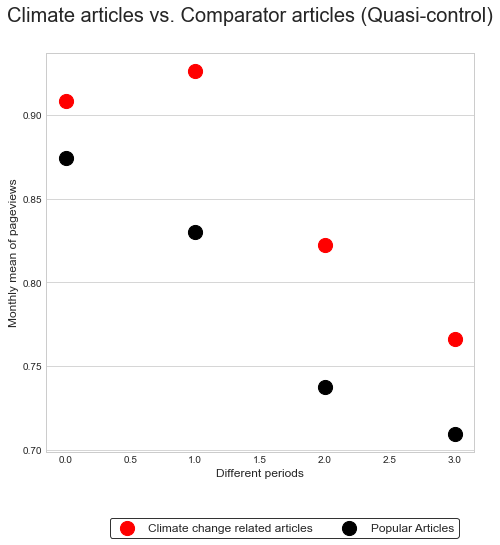

In [8]:
params={
    "title" : "Climate articles vs. Comparator articles (Quasi-control)",
    "xlabel" : "Different periods",
    "ylabel" : "Monthly mean of pageviews",
    "filename" : "climate_vs_quasicontrol_MEAN.png",
    "intervals" : INTERVALS
}
dfs=(sci_art_cc_monthly_mean, sci_art_control_monthly_mean)
plot_means(dfs=dfs, params=params)

---
### 3.1.2 Climate change articles VS Popular comparator group

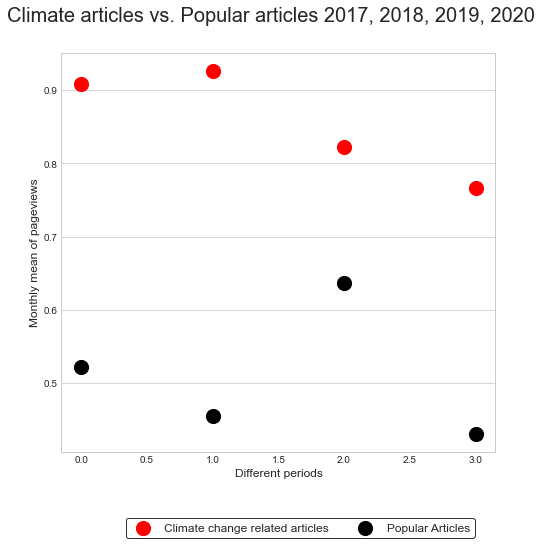

In [9]:
params={
    "title" : "Climate articles vs. Popular articles 2017, 2018, 2019, 2020",
    "xlabel" : "Different periods",
    "ylabel" : "Monthly mean of pageviews",
    "filename" : "climate_vs_pop_MEAN.png",
    "intervals" : INTERVALS
}
dfs=(sci_art_cc_monthly_mean, sci_art_pop_monthly_mean)
plot_means(dfs=dfs, params=params)

---

### 3.2 Interrupted Time Serie (ITS) - Linear regression

>Here we're defining the function to plot the ITS regression over months for 2 groups. The chosen events are displayed as vertical lines.

In [10]:
def plot_comparator(dfs, lin_reg_res, params)  :
    """Function that plots the data to compare 2 ITS. It must be given the results of 
    the linear regression and the timeserie with the numbering by month. As the linear
    regression function, it is possible to specify the interval of months for each period.
    All the params are given through dictionnary. The dataframes are given as a tuple and the
    corresponding results of the linear regression as well. The confidence area for each linear
    regression is plotted as an area.
    As follow : (df_studied, df_comparator)"""
    
    #~~~~~~~~~~~~~~~~~~~~~~ Extract parameter ~~~~~~~~~~~~~~~~~~~~~~
    keys=params.keys()
    title=params["title"] if "title" in keys else ""
    xlabel=params["xlabel"] if "xlabel" in keys else ""
    ylabel=params["ylabel"] if "ylabel" in keys else ""
    filename=params["filename"] if "filename" in keys else "no_name"
    #Names used to add in the legend
    names=params["names"] if "names" in keys else ["", ""]
    ci=params["ci"] if "ci" in keys else ""
    #axis limits
    TOP=params["top"] if "top" in keys else None
    BOTTOM=params["bottom"] if "bottom" in keys else None
    
        
    #~~~~~~~~~~~~~~~~~~~~~~ Custom intervals ~~~~~~~~~~~~~~~~~~~~~~
    #Get the list of intervals
    intervals = get_intervals_from_lagarde(dfs[0])
    
    #Check for customized interval
    for interval_number in range(1,len(intervals)+1) :
        if "custom_intervals" in keys :
            intervals[interval_number-1]=params["custom_intervals"][interval_number] if interval_number in params["custom_intervals"].keys() else intervals[interval_number-1]
    
    
    #~~~~~~~~~~~~~~~~~~~~~~ Fix limit of the axes ~~~~~~~~~~~~~~~~~~~~~~ 
    
    #Boundaries of the y-axis, it has been decided to keep them constant instead of relative by % of the
    #max and min value because it is easier to compare plot when the axes are constant
    BOTTOM=0 if BOTTOM is None else BOTTOM
    all_pageviews=[j for i in [list(dfs[0]["pageviews"]), list(dfs[1]["pageviews"])] for j in i]
    MAX=max(all_pageviews)
    TOP=MAX+0.1*MAX if TOP is None else TOP#1500000#100000000 

    #~~~~~~~~~~~~~~~~~~~~~~ Create the empty plot ~~~~~~~~~~~~~~~~~~~~~~
    
    fig, ax = plt.subplots(1,1,figsize= (11,7), sharey = True, sharex = True)
    
    #~~~~~~~~~~~~~~~~~~~~~~ Plotting all the data points of the serie ~~~~~~~~~~~~~~~~~~~~~~
    
    #Choose in advance the colors of the two groups
#     colors=[("black", "dimgray"), ("darkgrey", "silver")]
    colors=[("darkred", "firebrick", "indianred"), ("mediumaquamarine", "aquamarine", "paleturquoise")]
    #Plots the two plots, the second plot is the comparator group
    for df, reg, col, name in zip(dfs, lin_reg_res, colors, names) :
        #Just to have the correct keys for the reg dict and select
        #properly the right period
        name_interval=["-".join(inter) for inter in intervals]
        
        ax.scatter(x=df["months"],y=df["pageviews"], marker="o", s=50, c=col[0], label=f"{name}-related Articles")
        #Plotting linear regression
        for interval, n_inter, key in zip(intervals, name_interval,  list(range(1,len(intervals)+1,1))) :
            ax.plot(df.loc[interval[0]:interval[1]]["months"],
                    reg[key]["predicts"], #Take the data points of the regression from the dict
                    linewidth=4,
                    alpha=0.9,
                    c=col[1],
                    label=f"{name} Article Trend") #{n_inter}
        
        #~~~~~~~~~~~~~~~~~~~~~~ CI plot ~~~~~~~~~~~~~~~~~~~~~~
        #For each regression line, plot the upper CI values as a line and
        #the lower CI values. Filled the area between the two.
        periods = list(reg.values())[1:]
        for period, interval in zip(periods, intervals) :
            for _, ci_array in period["CI"].items() :
                ax.plot(df.loc[interval[0]:interval[1]]["months"],
                        ci_array,
                        linewidth=2,
                        alpha=0.1,
                        c=col[2]
                       )
            #Create a color area representing the CI
            plt.fill_between(df.loc[interval[0]:interval[1]]["months"],
                period["CI"]["lower"],
                period["CI"]["upper"],
                where=period["CI"]["upper"] >= period["CI"]["lower"],
                facecolor=col[2], alpha=0.25, interpolate=True, label=f"{name} Confidence Interval ({ci})")

    #~~~~~~~~~~~~~~~~~~~~~~ Visual modifications of the plot ~~~~~~~~~~~~~~~~~~~~~~
    
    ax.set_ylim(bottom=BOTTOM, top=TOP)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.xaxis.grid(False)
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.xaxis.set_tick_params(length = 5, width = 1)
    ax.yaxis.set_tick_params(length = 5, width = 1)
    #Plot tick bars
    ax.ticklabel_format(useOffset=False, style='plain')
    #Plot a vertical line to delimit the 2 intervals.
    #-0.5 to locate the mid of the month. (Since the frequency is end of month)
    for interval, counter in zip(intervals, list(range(1,len(intervals)+1,1)))  :
        #The event is located always as the first month of an interval except the first one
        if counter > 1 :
            event=float(df.loc[interval[0]]["months"]-0.5)
            plt.axvline(x=event, color = 'black', alpha=1, linewidth=3.5)
            #Indicate the mid June (Arbitrary addition values to center the label)
            ax.text(event-1.1, TOP, interval[0], fontsize=13)
    #Use to avoid "duplicates" in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left',fontsize=12,bbox_to_anchor=(0.135, -0.15),ncol=2,frameon=True,edgecolor="black")
    fig.tight_layout()
    fig.suptitle(title, y=1.07, fontsize=20)
    
    #~~~~~~~~~~~~~~~~~~~~~~ Save the plot in order to plot it further ~~~~~~~~~~~~~~~~~~~~~~
    
    plt.savefig(f"./plots/{filename}", format="png",bbox_inches='tight')

---
### 3.2.1 Climate change articles VS Quasi-control group

Climate change | Linear Regression interval 1 :

                             OLS Regression Results                            
Dep. Variable:              pageviews   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     13.66
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.80e-08
Time:                        11:52:01   Log-Likelihood:                 73.726
No. Observations:                  44   AIC:                            -131.5
Df Residuals:                      36   BIC:                            -117.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

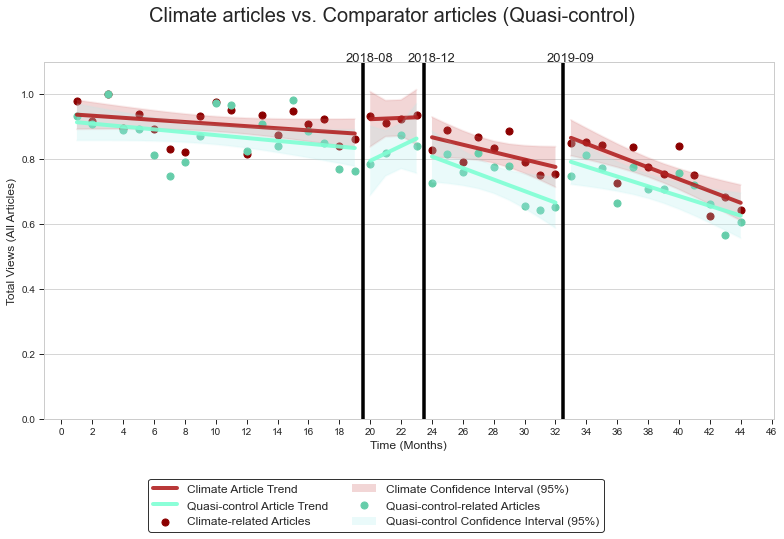

In [11]:
#Use the function 
params={
    "title" : "Climate articles vs. Comparator articles (Quasi-control)",
    "xlabel" : "Time (Months)",
    "ylabel" : "Total Views (All Articles)",
    "filename" : "climate_vs_quasicontrol.png",
    "ci" : "95%",
    "names" : ("Climate","Quasi-control"),
    "intervals" : INTERVALS,
    "bottom" : 0,
    "top" : 1.1
}
dfs=(sci_art_cc_agg, sci_art_control_agg)
regs=(sci_art_cc_reg, sci_art_control_reg)
plot_comparator(dfs=dfs, lin_reg_res=regs, params=params)

print(f"Climate change | Linear Regression interval 1 :\n\n {sci_art_cc_reg['results'].summary()}\n\n")
print(f"Quasi-control | Linear Regression interval 1 :\n\n {sci_art_control_reg['results'].summary()}\n\n")

>In the publication, the terrorism articles are compared to another quasi-control group. This group is made or security related articles that would arguably not be affected by the treatment but are similar enough in terms of topic to be used as a control group. The following cells present an attempt at the replication of that method.

> To be able to reproduce this method in our context, we need a group of articles that are likely to be affected by the treatment, namely that people would consult them more because of the mediatic movement around Greta Thunberg and climate change. The second group should be a group of articles that are similar to the first group such that any external bias would appear in both and therefore cancel out at comparison. It should also not be affected by the treatment, namely not be related to climate change issues. It is not straight forward to find a second group that would be used along with the first corpus that we considered, the corpus of the climate change related articles plotted above because this group is already quite broad. 

> To paliate to this problem, we restrained ourselves to scientific articles chosen in wikipedia index of articles randomly. The first group was selected randomly in a list of scientific articles on topics likely to be related to climate change (biodiversity, energy, meteo, pesticides, earth). The second group was selected randomly in a list of scientific articles on topics not related to climate change (anatomy, genetics, optics, philosophy, social). This pick has the advantage of showing if the public reads on scientific articles, which would confirm the hypothesis that people were encouraged to get educated on the topic of climate change. 

---
### 3.2.2 Climate change articles VS Popular comparator group

Climate change | Linear Regression interval 1 :

                             OLS Regression Results                            
Dep. Variable:              pageviews   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     13.66
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.80e-08
Time:                        11:52:02   Log-Likelihood:                 73.726
No. Observations:                  44   AIC:                            -131.5
Df Residuals:                      36   BIC:                            -117.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

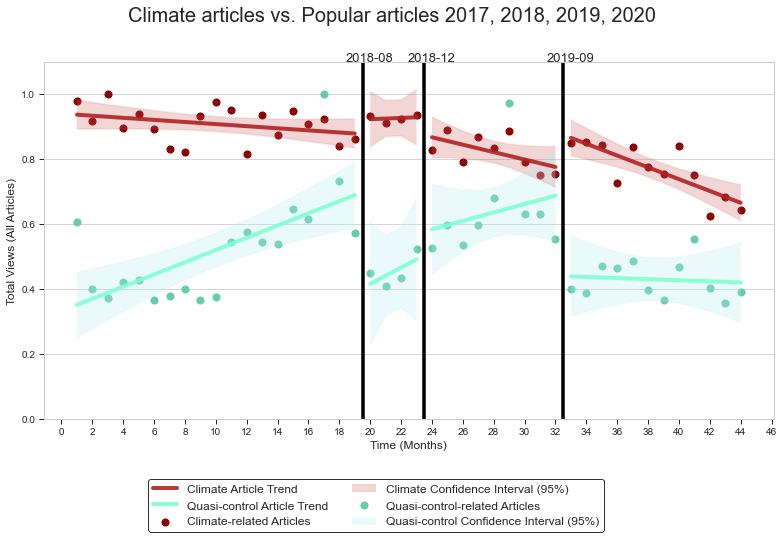

In [12]:
#Use the function 
params={
    "title" : "Climate articles vs. Popular articles 2017, 2018, 2019, 2020",
    "xlabel" : "Time (Months)",
    "ylabel" : "Total Views (All Articles)",
    "filename" : "climate_vs_pop.png",
    "ci" : "95%",
    "names" : ("Climate","Quasi-control"),
    "intervals" : INTERVALS,
    "bottom" : 0,
    "top" : 1.1
}
dfs=(sci_art_cc_agg, sci_art_pop_agg)
regs=(sci_art_cc_reg, sci_art_pop_reg)
plot_comparator(dfs=dfs, lin_reg_res=regs, params=params)

print(f"Climate change | Linear Regression interval 1 :\n\n {sci_art_cc_reg['results'].summary()}\n\n")
print(f"Popular articles | Linear Regression interval 1 :\n\n {sci_art_pop_reg['results'].summary()}\n\n")

---
## 4 Checking correctness

### 4.1 Checking outliers

Firstly we can check the Cooks D values from the regression of each dataset to detect the presence of potential outliers.

>Details : Cook's D 

>>><img src="./cooksD.png">

>> Where $y_j$ — the jth fitted response value, $y_{j(i)}$ — the jth fitted response value, where the fit does not include observation $i$, $p$ — the number of regression coefficients, $\sigma$ — the estimated variance from the fit, based on all observations, i.e. Mean Squared Error

>>If a data point has a Cook’s distance of more than three times the mean, it is a possible outlier. Any point over 4/n, where n is the number of observations, should be examined. (https://medium.com/@lymielynn/a-little-closer-to-cooks-distance-e8cc923a3250)

In [18]:
import statsmodels.stats.outliers_influence
#Give the list of Cook's D distance from the result of the regression
for name, reg in zip(("Climate change", "Quasi-control", "Popular articles"),(sci_art_cc_reg, sci_art_control_reg, sci_art_pop_reg)) :
    cooksD=statsmodels.stats.outliers_influence.OLSInfluence(reg["results"]).cooks_distance
    print(f"{name} :\n{cooksD[0].sort_values(ascending=False).head(10)}\n")
    print(f"Threshold for outlier according to the mean \t: {cooksD[0].mean()*3}")
    print(f"Threshold for outlier according to 4/n \t\t: {4/len(cooksD[0])}\n")

Climate change :
Date
2018-12-01    0.079129
2020-06-01    0.069743
2020-04-01    0.064566
2019-12-01    0.060056
2019-05-01    0.048028
2018-08-01    0.045842
2017-03-01    0.044274
2019-02-01    0.036017
2019-07-01    0.031547
2017-07-01    0.028643
dtype: float64

Threshold for outlier according to the mean 	: 0.055947832838555096
Threshold for outlier according to 4/n 		: 0.09090909090909091

Quasi-control :
Date
2018-12-01    0.197252
2018-11-01    0.130721
2020-07-01    0.064785
2018-03-01    0.062784
2017-03-01    0.052535
2017-07-01    0.048956
2018-07-01    0.048408
2018-06-01    0.036229
2019-12-01    0.035188
2019-09-01    0.035033
dtype: float64

Threshold for outlier according to the mean 	: 0.07012468328003935
Threshold for outlier according to 4/n 		: 0.09090909090909091

Popular articles :
Date
2018-05-01    0.225618
2017-01-01    0.195028
2019-05-01    0.176234
2019-08-01    0.173685
2018-08-01    0.079707
2018-11-01    0.076551
2018-07-01    0.041550
2018-12-01    0.0

We can see there are some outlieres in each dataset. Let's use the z-score to find the article that creates this effect.

We can verify the presence of outliers using the z-score as the paper did. Whether an article has a z-score superior to 3.0 or inferior to -3.0, it might be considered as an outlier. The z-score will be computed of the aggregated dataframe grouped by article.

>Z-score
>><img src="./zscore.png">

>>Where $x_i$ is an entry, $\overline{x}$ the mean of the data and $s$ the standard deviation.

In [28]:
def zscore(df) :
    "Compute the z-score for all articles"
    df=df.copy().T.sum(axis=1).drop(index="Date")
    df=df.apply(lambda x : (x-df.mean())/df.std())
    
    return df

for name, df in zip(("Climate change", "Quasi-control", "Popular articles"),(sci_art_cc, sci_art_control, sci_art_pop)) :
    
    print(f"{name} :\n{zscore(df).sort_values(ascending=False).head(10)}\n")

Climate change :
Health                3.148997
Life expectancy       3.114913
Humanism              2.830032
Green Revolution      1.979894
DDT                   1.960547
Population growth     1.452652
Endemism              1.395937
Human geography       0.403241
Troposphere           0.400976
Vulnerable species    0.170290
dtype: float64

Quasi-control :
Galileo Galilei          4.086586
Autism                   3.387575
Bacteria                 2.147020
Kidney                   1.627893
Murder                   1.445185
Bone                     0.882960
Neurology                0.819529
Cognition                0.708434
Quantitative research    0.403352
Intelligence             0.395496
dtype: float64

Popular articles :
Donald Trump                               2.822261
Elizabeth II                               2.325575
United States                              1.604087
Freddie Mercury                            1.421617
Meghan, Duchess of Sussex                  1.290487
List o

We can consider that the outliers for the climate change dataset are Health, Life expectancy and Humanism, it is logical since these themes are linked to other matter that only the climate change. For the control dataset about scientific articles, we can see the Galileo Galilei and Autism are outliers. Finally Donald Trump is an outlier for the popular articles. We can drop them in the aggregate.

In [29]:
sci_art_cc_agg_wo=aggregate(df=sci_art_cc, normalization=True)
sci_art_control_agg_wo=aggregate(df=sci_art_control, normalization=True)
sci_art_pop_agg_wo=aggregate(df=sci_art_pop, normalization=True)

### 4.2 Checking auto-correlation

A linear regression of a time serie may suffer of auto-correlation : this is the fact that a given value might be influenced by a previous value of the time serie according a certain lag. (e.g. a year seasonality with a lag of 365).
The authors have used the test of Prais-Winsten to detect the auto-correlation. Here we used the plot_acf() function from statsmodel to detect the presence of autocorrelation according to all the possible values of lag. Whether the auto-correlation value is not in the confidence interval, the lag is considered to have an auto-correlation

<Figure size 432x288 with 0 Axes>

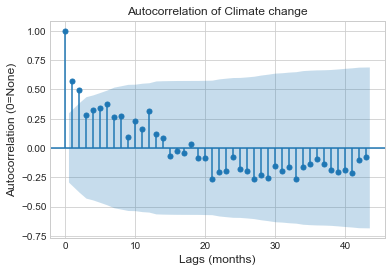

<Figure size 432x288 with 0 Axes>

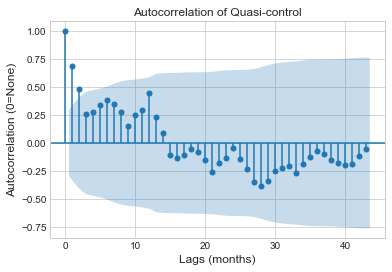

<Figure size 432x288 with 0 Axes>

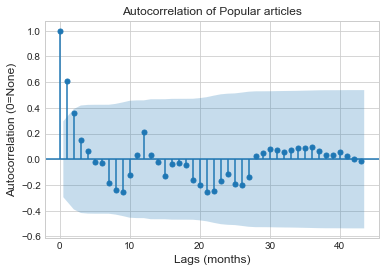

In [31]:
from statsmodels.graphics.tsaplots import plot_acf


for name, df in zip(("Climate change", "Quasi-control", "Popular articles"),(sci_art_cc_agg_wo, sci_art_control_agg_wo, sci_art_pop_agg_wo)) :
    plt.figure()
    ax1=plot_acf(df['pageviews'], lags=int(len(df['pageviews'])-1), title=f"Autocorrelation of {name}");
    plt.xlabel("Lags (months)", fontsize=12)
    plt.ylabel("Autocorrelation (0=None)", fontsize=12)


We can see there are correlations of lag 1 and 2 along all the datasets. Except for popular articles, it is logical since the popular articles are trendy during a short period then their count of pageviews doesn't evolve much for the remaining period.


In [ ]:
# import statistics
# def correct_autocorrelation(df, lag):
#     """Compute all the differences between 2 elements distant by a certain shift suffering 
#     from autocorrelation. Then the difference is added to the original value of the timeserie
#     to correct the autocorrelation. The drawback is that the first value of the timeserie cannot
#     be correct since we have not the previous value according to the lag."""
#     diff = list()
#     df=df.copy()
#     for i in range(lag, len(df)):
#         value = df["pageviews"].iat[i] - df["pageviews"].iat[i - lag]
#         diff.append(value)
#     #Correct all the values according to the lag except the first one that cannot be corrected without the previous value
#     #Mean imputation
#     diff=[statistics.mean(diff)]+diff
#     df["pageviews"]=diff
# #     df["pageviews"].iloc[1:]=df["pageviews"].iloc[1:]+diff
#     return df


# domest_ag_wo_wa=correct_autocorrelation(domest_ag_wo, 1)
# plt.figure()
# ax1=plot_acf(domest_ag_wo_wa['pageviews'], lags=int(len(domest_ag_wo_wa['pageviews'])-1), title="Autocorrelation of corrected domestic-related dataset over months");
# plt.xlabel("Lags (months)", fontsize=12)
# plt.ylabel("Autocorrelation (0=None)", fontsize=12)

# ter30_ag_wa=correct_autocorrelation(ter30_ag, 1)
# plt.figure()
# ax1=plot_acf(ter30_ag_wa['pageviews'], lags=int(len(ter30_ag_wa['pageviews'])-1), title="Autocorrelation of corrected terrorism-related dataset over months");
# plt.xlabel("Lags (months)", fontsize=12)
# plt.ylabel("Autocorrelation (0=None)", fontsize=12)

# We reduced the autocorrelation of lag 1 to a level very close to the confidence interval. The result is deemed acceptable to continue. It should be noted, however, that the authors did not detect autocorrelation at this stage but at the following one, which marks a difference.

## 5 Replotting the corrected datasets

In [6]:
#Recompute linear regression
sci_art_control_reg_wo=lin_reg_period_lagarde(df=sci_art_control_agg_wo)
sci_art_cc_reg_wo=lin_reg_period_lagarde(df=sci_art_cc_agg_wo);
sci_art_pop_reg_wo=lin_reg_period_lagarde(df=sci_art_pop_agg_wo);

#Recompute mean
sci_art_cc_monthly_mean_wo = periods_avg(sci_art_cc_agg_wo, INTERVALS)
sci_art_control_monthly_mean_wo = periods_avg(sci_art_control_agg_wo, INTERVALS)
sci_art_pop_monthly_mean_wo = periods_avg(sci_art_pop_agg_wo, INTERVALS)


#Plot mean comparison


params={
    "title" : "Climate articles vs. Comparator articles (Quasi-control)\nWithout outliers",
    "xlabel" : "Different periods",
    "ylabel" : "Monthly mean of pageviews",
    "filename" : "climate_vs_quasicontrol_MEAN_wo.png",
    "intervals" : INTERVALS
}
dfs=(sci_art_cc_monthly_mean_wo, sci_art_control_monthly_mean_wo)
plot_means(dfs=dfs, params=params)

params={
    "title" : "Climate articles vs. Popular articles 2017, 2018, 2019, 2020\nWithout outliers",
    "xlabel" : "Different periods",
    "ylabel" : "Monthly mean of pageviews",
    "filename" : "climate_vs_pop_MEAN_wo.png",
    "intervals" : INTERVALS
}
dfs=(sci_art_cc_monthly_mean_wo, sci_art_pop_monthly_mean_wo)
plot_means(dfs=dfs, params=params)




#Plot regression comparison 
params={
    "title" : "Climate articles vs. Comparator articles (Quasi-control)\nWithout outliers",
    "xlabel" : "Time (Months)",
    "ylabel" : "Total Views (All Articles)",
    "filename" : "climate_vs_quasicontrol_wo.png",
    "ci" : "95%",
    "names" : ("Climate","Quasi-control"),
    "intervals" : INTERVALS,
    "bottom" : 0,
    "top" : 1.1
}
dfs=(sci_art_cc_agg_wo, sci_art_control_agg_wo)
regs=(sci_art_cc_reg_wo, sci_art_control_reg_wo)
plot_comparator(dfs=dfs, lin_reg_res=regs, params=params)

print(f"Climate change | Linear Regression interval 1 :\n\n {sci_art_cc_reg['results'].summary()}\n\n")
print(f"Quasi-control | Linear Regression interval 1 :\n\n {sci_art_control_reg['results'].summary()}\n\n")


#Use the function 
params={
    "title" : "Climate articles vs. Popular articles 2017, 2018, 2019, 2020\nWithout outliers",
    "xlabel" : "Time (Months)",
    "ylabel" : "Total Views (All Articles)",
    "filename" : "climate_vs_pop_wo.png",
    "ci" : "95%",
    "names" : ("Climate","Quasi-control"),
    "intervals" : INTERVALS,
    "bottom" : 0,
    "top" : 1.1
}
dfs=(sci_art_cc_agg_wo, sci_art_pop_agg_wo)
regs=(sci_art_cc_reg_wo, sci_art_pop_reg_wo)
plot_comparator(dfs=dfs, lin_reg_res=regs, params=params)

print(f"Climate change | Linear Regression interval 1 :\n\n {sci_art_cc_reg['results'].summary()}\n\n")
print(f"Popular articles | Linear Regression interval 1 :\n\n {sci_art_pop_reg['results'].summary()}\n\n")

## 6 Interpretation